In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Daily Data - last 365 rows

from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [114]:
# Want precipitation data from 8/23/2016 to 8/23/2017

measurement_data = []
for row in session.query(Measurement.date,Measurement.prcp).all():
    measurement_data.append(row)
    
measurement_df = pd.DataFrame(measurement_data,columns =['date','precipitation'])

measurement_date_index = measurement_df.set_index('date')

measurement_sorted = measurement_date_index.sort_index(ascending=True)

Aug2016_Aug2017 = measurement_sorted.loc['2016-08-23':'2017-08-23']

Aug2016_Aug2017_no_null = Aug2016_Aug2017.dropna(subset=['precipitation'])

Aug2016_Aug2017_no_null.head()
    

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.70
2016-08-23,1.79
2016-08-23,0.02
2016-08-23,0.15


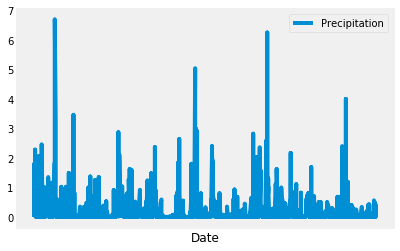

In [115]:
fig, ax = plt.subplots()
plt.plot(Aug2016_Aug2017_no_null,label='Precipitation')
ax.tick_params(labelbottom=False)
ax.set_xlabel('Date')

ax.legend()
ax.grid()
plt.savefig("./Images/Precipitation.png")
plt.show()

In [116]:
# Use Pandas to calcualte the summary statistics for the precipitation data

Aug2016_Aug2017_no_null.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [237]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Measurement.station).group_by(Measurement.station).count()
station_count

9

In [238]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

new_station = []
unique_station = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc())
for station in unique_station:
    new_station.append(station)
new_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [239]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

active = []
most_active = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.\
avg(Measurement.tobs)).filter_by(station='USC00519281')
for num in most_active:
    active.append(num)
active

[(54.0, 85.0, 71.66378066378067)]